The following function below is taken from [https://scipy-cookbook.readthedocs.io/items/BrownianMotion.html](https://scipy-cookbook.readthedocs.io/items/BrownianMotion.html) and modified. The function is modified so that it can simulate m random walks at once. Implemanting many random walks at once using vectorization allows to get rid of for loops, which makes the implementation faster. The delta, which determines the speed of the Brownian motion is set to 1. Therefore, the steps of each random walk is drawn from a Gaussian distribution with mean zero and variance equal to time step $\Delta$t. The initial value is included in the array unlike the solution given in the website. Including it or not does not change the calculation for P(X<0|y=0 for the first time) at all.

In [1]:
from math import sqrt
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

sns.set(color_codes=True)
%matplotlib inline
seed = 1

In [2]:
def brownian(x0, n, dt, m=1, delta=1):
    """
    Generates an instance of Brownian motion (i.e. the Wiener process):

        X(t) = X(0) + N(0, delta**2 * t; 0, t)

    where N(a,b; t0, t1) is a normally distributed random variable with mean a and
    variance b.  The parameters t0 and t1 make explicit the statistical
    independence of N on different time intervals; that is, if [t0, t1) and
    [t2, t3) are disjoint intervals, then N(a, b; t0, t1) and N(a, b; t2, t3)
    are independent.
    
    Written as an iteration scheme,

        X(t + dt) = X(t) + N(0, delta**2 * dt; t, t+dt)


    If `x0` is an iterator, each value in `x0` is treated as
    an initial condition.

    Arguments
    ---------
    x0      : Numpy array or an iterator that can be converted to a numpy array
              using numpy.asarray(x0), which is the initial condition(s) (i.e. position(s)) of the Brownian motion 
              in 2-D.
    n       : The number of steps to take.
    dt      : The time step.
    delta   : Determines the "speed" of the Brownian motion.  
    m       : The number of walks performed

    Returns
    -------
    A numpy array of shape=(x0.shape, n+1, m), which contains the position of the partcile at each time instant
    for each ransom walk m.
    
    Note that the initial value `x0` is included in the returned array.
    """

    x0 = np.asarray(x0)
    x0 = x0.reshape(1,x0.shape[0],1)
    x0 = x0 * np.ones((m,x0.shape[1],1)) # Broadcasting

    # For each element of x0, generate a sample of n numbers from a
    # normal distribution.
    r = norm.rvs(size=(m, x0.shape[1], n), scale=delta*sqrt(dt))
    r = np.dstack((x0, r))

    # The result will be stored in out
    out = np.empty(r.shape)
    
    # This computes the Brownian motion by forming the cumulative sum of
    # the random samples. 
    np.cumsum(r, axis=-1, out=out)

    return out

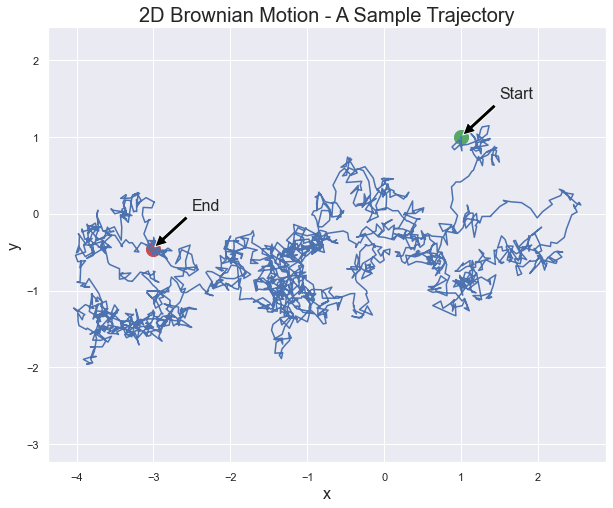

In [10]:
# Total time.
T = 10.0
# Number of steps.
N = 2000
# Time step size
dt = T/N
# Initial values of x.
x0 = [1,1]

x = brownian(x0, N, dt)[0]

# Plot the 2D trajectory.
fig = plt.figure(figsize=(10,8))
plt.plot(x[0],x[1])

# Mark the start and end points.
plt.scatter(x[0,0],x[1,0], c='g', s=200)
plt.scatter(x[0,-1], x[1,-1], c='r', s=200)

plt.title('2D Brownian Motion - A Sample Trajectory', fontsize=20)
plt.annotate('Start', xy=(1, 1), xytext=(1.5, 1.5), fontsize=16,
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('End', xy=(x[0,-1], x[1,-1]), xytext=(x[0,-1]+0.5, x[1,-1]+0.5), fontsize=16,
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.axis('equal')
plt.grid(True)
plt.show()

### Let's perform the simulations using a for loop

In [11]:
# Total time.
T = 10.0
# Number of steps.
N = 2000
# Time step size
dt = T/N

# Variable to hold the number of times x is negative when the path crosses y=0 for the first time
totNeg = 0
# Variable to hold the number of times x is positive or zero when the path crosses y=0 for the first time
totPos = 0

# Number of times the simulatio will be run. The more is better
simNumber = 100000

start = time.time()
for sim in range(simNumber):
    
    x0 = [1,1]
    random_walk = brownian(x0, N, dt)[0]
    
    # The line below gives the index when it reaches exactly zero as well
    zero_crossings = np.nonzero(np.diff(np.sign(random_walk[1,:])))[0]
   
    if zero_crossings.size != 0:
        zeroCrossing = zero_crossings[0]
    
        # Let's find the x-value for the zero crossing
        if random_walk[0,zeroCrossing] < 0:
            totNeg+=1
        else:
            totPos+=1
end = time.time()
print('Time needed for the simulations to complete: {:.2f} minutes\n'.format((end - start)/60))

print('The estimated probability of P(X<0|y=0 for the first time) is %.2f' %(totNeg/(totNeg+totPos)))    

Time needed for the simulations to complete: 0.33 minutes

The estimated probability of P(X<0|y=0 for the first time) is 0.19


The code snippet above uses a for loop to perform 10000 random walks. Below, the code above is vectorized instead to perform the 10000 random walks without using a for loop. 

### Vectorization of the Code Above

In [12]:
# Total time.
T = 10.0
# Number of steps.
N = 2000
# Time step size
dt = T/N

# Variable to hold the number of times x is negative when the path crosses y=0 for the first time
totNeg = 0
# Variable to hold the number of times x is positive or zero when the path crosses y=0 for the first time
totPos = 0

# Number of times the simulatio will be run. The more is better
simNumber = 100000

start = time.time()
    
x0 = [1,1]
random_walk = brownian(x0, N, dt, simNumber)
y = random_walk[:,1,:]
  
# Find the zero crossings for each random walk    
any_crossing = (y <= 0).any(1) 
index = (y[any_crossing] <= 0).argmax(1)

# Get the x-value and check if it is less than 0
x = random_walk[:,0,:]
result = (x[any_crossing,index] < 0)

totNeg = sum(result)

end = time.time()
print('Time needed for the simulations to complete: {:.2f} minutes\n'.format((end - start)/60))

print('The estimated probability of P(X<0|y=0 for the first time) is %.2f' %(totNeg/len(result)))  

Time needed for the simulations to complete: 0.26 minutes

The estimated probability of P(X<0|y=0 for the first time) is 0.19


The same probability is achieved with less time. The time difference will be larger if more than 100000 random walks are performed. 

### Cumulative Distribution

Let's perform another simulation to get a feel of what the distribution may look like for P(X<x|y=0 for the first time) for different values of x. 

In [13]:
# Total time.
T = 10.0
# Number of steps.
N = 2000
# Time step size
dt = T/N

# Variable to hold the number of times x is negative when the path crosses y=0 for the first time
totNeg = 0
# Variable to hold the number of times x is positive or zero when the path crosses y=0 for the first time
totPos = 0

# Number of times the simulatio will be run. The more is better
simNumber = 10000
# x-axis coordinated to compare
xVal = np.linspace(-15,16,100)

prob = {}

start = time.time()
for T in xVal:
    
    # Variable to hold the number of times x is negative when the path crosses y=0 for the first time
    totNeg = 0
    # Variable to hold the number of times x is positive or zero when the path crosses y=0 for the first time
    totPos = 0

    x0 = [1,1]
    random_walk = brownian(x0, N, dt, simNumber)
    y = random_walk[:,1,:]

    # Find the zero crossings for each random walk    
    any_crossing = (y <= 0).any(1) 
    index = (y[any_crossing] <= 0).argmax(1)

    # Get the x-value and check if it is less than 0
    x = random_walk[:,0,:]
    result = (x[any_crossing,index] < T)

    totNeg = sum(result)
                
    prob[T] = totNeg/len(result)
end = time.time()
print('Time needed for the simulations to complete: {:.2f} minutes\n'.format((end - start)/60))

Time needed for the simulations to complete: 2.20 minutes



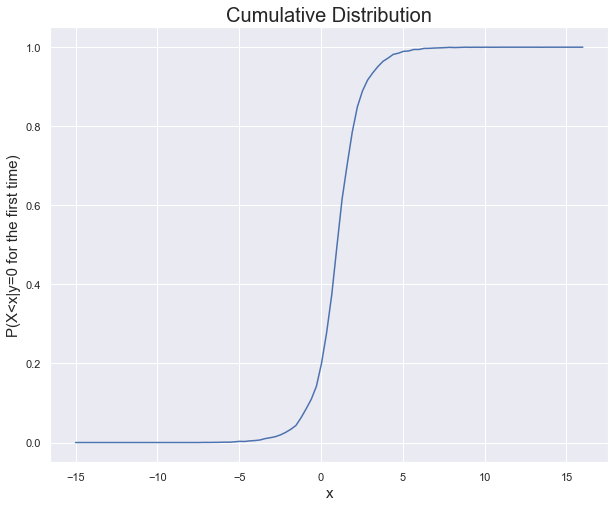

In [14]:
plt.figure(figsize=(10,8))
plt.plot(list(prob.keys()), list(prob.values())) 
plt.xlabel('x', fontsize=15)
plt.ylabel('P(X<x|y=0 for the first time)', fontsize=15)
plt.title('Cumulative Distribution', fontsize=20);

As can be seen from the figure above, the cumulative distribution approaches 1 for large values of x where the particle crosses the x-axis (y=0). The probability approaches zero for negative values of x. Since the initial position of the particle is (1,1), the value of P(X<1|y=0 for the first time) is estimated as 0.5 from the simulations as expected. The cumulative disribituiton looks like a shifted sigmoid which is expected as well.    